In [2]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [3]:
df = pd.read_json(open("result.json"))
df = pd.DataFrame(df[df.function.isin(['merge-100000', 'pandas_groupby-2880-1s-16H', 'merge_slow-20000-1', 'merge_slow-20000-0.1'])])
print(df.function.unique())
RENAMES = [
    lambda s: re.sub(r"^(pandas_)(.*)", r"\2", s),
    lambda s: re.sub(r"^(wordbatch_)(.*)", r"\2", s),
    lambda s: re.sub(r"(.*)(wordbatch.csv-)(.*)", r"\1\3", s),
    lambda s: re.sub(r"(.*)(000000)(-|$)(.*)", r"\1M\3\4", s),
    lambda s: re.sub(r"(.*)(000)(-|$)(.*)", r"\1K\3\4", s),
    lambda s: re.sub(r"(.*)1s(.*)", r"\g<1>1S\2", s)
]

def rename_benchmark(name):
    for regex in RENAMES:
        name = regex(name)
    return name


def fix(name):
    name = name.replace("dask-1n", "dask-ws-1n")
    name = name.replace("dask-7n", "dask-ws-7n")
    return name
df["cluster"] = df.cluster.apply(fix)

def extract_nodes(data):
    name = data.cluster.split("-")
    return int(name[3][:-1])

df["function"] = df.function.apply(lambda x: rename_benchmark(x))
df["scheduler"] = df.cluster.apply(lambda x: x.split("-")[1])
df["nodes"] = df.apply(extract_nodes, axis=1)
df["workers"] = df["nodes"] * 24
df["benchmark"] = df["function"]

serverkey = "server"
df[serverkey] = df.cluster.apply(lambda x: x.split("-")[0])

['merge-100000' 'pandas_groupby-2880-1s-16H' 'merge_slow-20000-0.1'
 'merge_slow-20000-1']


In [11]:
df["nodes"].unique()

array([ 7,  9, 11, 13, 15, 23, 31,  1, 47, 63])

In [12]:
a = df[df["benchmark"] == "merge_slow-20K-0.1"]
#a = a[a["server"] == "rsds"]
a.groupby(["server", "nodes"])["time"].mean()

server  nodes
dask    1        92.215294
        7        20.917830
        15       16.103272
        23       15.995607
        31       16.983087
        47       20.797323
        63       24.568692
rsds    1        88.526055
        7        16.166110
        15        9.909606
        23        8.318894
        31        7.575028
        47        7.457884
        63        7.743302
Name: time, dtype: float64

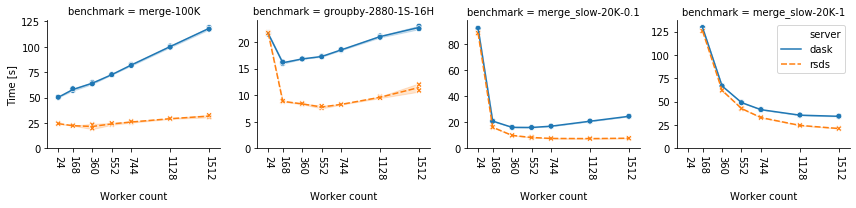

In [4]:
examined_nodes = [1, 7, 15, 23, 31, 47, 63]
df = df[df["nodes"].isin(examined_nodes)]

def plot(data, **kw):
    sns.lineplot(data=data, x="workers", y="time", ci="sd", hue=serverkey, style=serverkey)
    sns.scatterplot(data=data, x="workers", y="time", hue=serverkey, style=serverkey, legend=False)
    ticks = sorted(df.workers.unique())
    plt.xticks(ticks)

#gdata = df.groupby(["function", "runtime", "scheduler", "nodes"])["time"].mean()
#gdata
#plt.title()

data = df[df.scheduler == "ws"]  # sanity check
g = sns.FacetGrid(df, col="benchmark", col_wrap=4, sharey=False, sharex=True, legend_out=False)
g = g.map_dataframe(plot)
g.add_legend()
g.set_ylabels("Time [s]")
g.set_xlabels("Worker count", labelpad=10)
g.set(ylim=(0, None))
#plt.subplots_adjust(top=0.83)
#g.fig.suptitle('Strong scaling on selected benchmarks')
#plt.xscale("log")
g.fig.get_axes()[0].get_legend().remove()
g.set_xticklabels(rotation=-90)
g.fig.get_axes()[3].legend(loc='upper right')
plt.tight_layout()
plt.savefig("scaling.pdf")
plt.show()

[23, 'dask', 'ws', 'sw', '23n', '24p', '1t']
[9, 'rsds', 'ws', 'sw', '9n', '24p', '1t']
[1, 'dask', 'ws', 'sw', '1n', '24p', '1t']
[13, 'rsds', 'ws', 'sw', '13n', '24p', '1t']
[15, 'rsds', 'ws', 'sw', '15n', '24p', '1t']
[7, 'rsds', 'ws', 'sw', '7n', '24p', '1t']
[11, 'dask', 'ws', 'sw', '11n', '24p', '1t']
[47, 'dask', 'ws', 'sw', '47n', '24p', '1t']
[63, 'dask', 'ws', 'sw', '63n', '24p', '1t']
[1, 'rsds', 'ws', 'sw', '1n', '24p', '1t']
[63, 'rsds', 'ws', 'sw', '63n', '24p', '1t']
[9, 'dask', 'ws', 'sw', '9n', '24p', '1t']
[31, 'rsds', 'ws', 'sw', '31n', '24p', '1t']
[15, 'dask', 'ws', 'sw', '15n', '24p', '1t']
[7, 'dask', 'ws', 'sw', '7n', '24p', '1t']
[47, 'rsds', 'ws', 'sw', '47n', '24p', '1t']
[23, 'rsds', 'ws', 'sw', '23n', '24p', '1t']
[13, 'dask', 'ws', 'sw', '13n', '24p', '1t']
[11, 'rsds', 'ws', 'sw', '11n', '24p', '1t']
[31, 'dask', 'ws', 'sw', '31n', '24p', '1t']


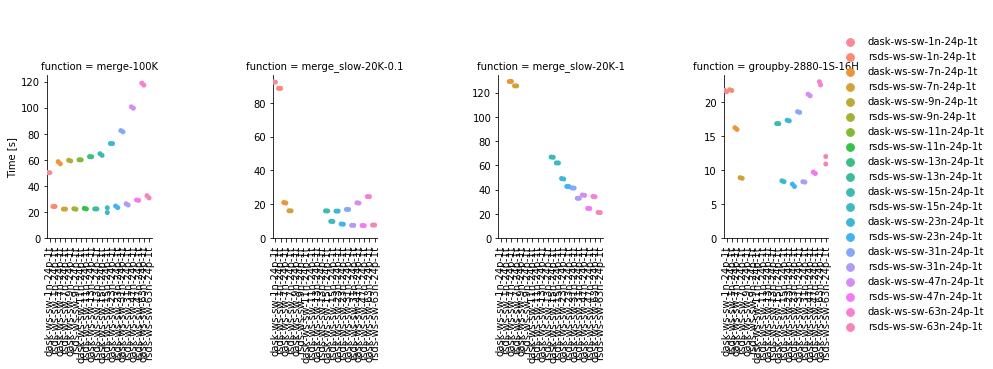

In [14]:
def create_plot(frame, plot_fn):
    def extract(fn):
        sortkey = []
        for item in fn.split("-"):
            try:
                num = float(item)
                sortkey.append(num)
            except:
                pass
        return tuple(sortkey)
    
    
    def cluster_key(name):        
        t = name.split("-")
        for x in t:
            if x and x[0].isdigit():
                break        
        key = [int(x[:-1])] + t
        print(key)
        return key
    
    clusters = sorted(set(frame["cluster"]), key=cluster_key)
    functions = sorted(frame["function"].unique(), key=extract)

    def plot(data, **kwargs):
        plot_fn(data, clusters, **kwargs)

    g = sns.FacetGrid(frame, col="function", col_wrap=4, col_order=functions, sharey=False)
    g = g.map_dataframe(plot)
    g = g.add_legend()
    g.set_ylabels("Time [s]")
    g.set(ylim=(0, None))
    g.set_xticklabels(rotation=90)
    return g

def plot_scatter(data, clusters, **kwargs):
    y = data["time"]
    sns.swarmplot(x=data["cluster"], y=y, hue=data["cluster"], order=clusters, hue_order=clusters)


#selection = df[df.function.isin(["xarray-5", "tree-15", "pandas_groupby-90-1s-8H", "numpy-50000-10"])]
selection = df
create_plot(selection, plot_scatter)
plt.show()
#plt.savefig('ws_sample.png', bbox_inches='tight')